In [16]:
# 清空内核状态
%reset -f

In [17]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [18]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([7.2])
target_y0=torch.tensor([0.0])
target_z0=torch.tensor([0.0])
target_vx0=torch.tensor([1.0])
target_vy0=torch.tensor([5.0])#这里是通行α粒子数据
target_vz0=torch.tensor([0.0])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=2e-3

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=1#lpde权重
lamda2=400#lE权重
lamda3=600#l0权重




In [19]:
n=100#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=50000#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=10#每几次epoch就计数

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.2.longsuifail"  # 新的文件名前缀

In [20]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [21]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [22]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [23]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS(u):
    
    samples = torch.arange(jump*interval, (n_all+1+jump)*interval, step=int(n_all/n)*interval)+torch.rand(n+1) * interval*int(n_all/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0


In [24]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [25]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::int(n_all/n_test)][:(n_test+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::int(n_all/n_test)][:(n_test+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::int(n_all/n_test)][:(n_test+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)



#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):1]
y_plt=ydata[jump:(n_all+1+jump):1]
z_plt=zdata[jump:(n_all+1+jump):1]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)
vxdata = (np.loadtxt('通行vx_real.txt'))*1e-6
vydata = (np.loadtxt('通行vy_real.txt'))*1e-6
vzdata = (np.loadtxt('通行vz_real.txt'))*1e-6
vx_real_plt=torch.tensor(vxdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vy_real_plt=torch.tensor(vydata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vz_real_plt=torch.tensor(vzdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
xdata=[]
ydata=[]
zdata=[]
vxdata=[]
vydata=[]
vzdata=[]#清空这二百四十万个数据

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [26]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
lamda2_list=[]#能量项权重
lamda3_list=[]#初态权重
l_withoutweight_list=[]#总损失，不带权重
time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
miu_train_list=[]

In [27]:
import time
start_time = time.time()#计时
epochs = 20000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    
    lpde=LOSS(u)[0]
    lE=LOSS(u)[1]
    l0=LOSS(u)[2]
  
    if (i+1)%1000== 0:
        gradient_lpde=funcweight(lpde)
        gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>1e-5:
        lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
    if (i+1)%1000== 0 and lE>1e-5:
        lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0*5+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    
    if (i+1)%1000 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.94
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_all+1+jump), interval*int(n_all/n_test))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        loss_test = loss(x_test,x_real)+loss(y_test,y_real)+loss(z_test,z_real)
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        #lcq=lE+lmiu_test#注意这里！！
        lossmean_test = torch.sum(x_test-x_real+y_test-y_real+z_test-z_real)/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
        lamda1_list.append(lamda1)
        lamda2_list.append(lamda2)
        lamda3_list.append(lamda3)
        l_withoutweight_list.append(l_withoutweight.item())
        time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
        miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


Epoch [1/20000], Loss: 3.461e+05,   LOSS_function: 1.321e+05,   LOSS_E:24.86,    LOSS_initial: 68.01,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 0.08495903015136719
loss_compared with real:57.45,   miu_train:0.005888,    lossmean:0.139
Epoch [10/20000], Loss: 1.052e+05,   LOSS_function: 1397,   LOSS_E:23.91,    LOSS_initial: 31.43,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 0.7603957653045654
loss_compared with real:116.49,   miu_train:0.008886,    lossmean:2.562
Epoch [20/20000], Loss: 7.315e+04,   LOSS_function: 1078,   LOSS_E:24.03,    LOSS_initial: 20.82,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 1.4920406341552734
loss_compared with real:96.822,   miu_train:0.005109,    lossmean:3.412
Epoch [30/20000], Loss: 2.882e+04,   LOSS_function: 1007,   LOSS_E:22.99,    LOSS_initial: 6.204,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 2.1743648052215576
loss_compared with real:

Epoch [320/20000], Loss: 1805,   LOSS_function: 540.9,   LOSS_E:2.663,    LOSS_initial: 0.0663,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 21.929170608520508
loss_compared with real:80.185,   miu_train:0.004069,    lossmean:0.5284
Epoch [330/20000], Loss: 1721,   LOSS_function: 525.5,   LOSS_E:2.588,    LOSS_initial: 0.05338,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 22.650900840759277
loss_compared with real:80.639,   miu_train:0.003762,    lossmean:0.5255
Epoch [340/20000], Loss: 1563,   LOSS_function: 200.8,   LOSS_E:2.422,    LOSS_initial: 0.1311,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 23.37005853652954
loss_compared with real:79.014,   miu_train:0.003636,    lossmean:0.5518
Epoch [350/20000], Loss: 1492,   LOSS_function: 383.7,   LOSS_E:2.373,    LOSS_initial: 0.05302,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 24.11420488357544
loss_compared with real:78.801,  

Epoch [640/20000], Loss: 810.9,   LOSS_function: 223.1,   LOSS_E:0.8555,    LOSS_initial: 0.08187,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 45.23763990402222
loss_compared with real:69.27,   miu_train:0.004802,    lossmean:0.6889
Epoch [650/20000], Loss: 673.3,   LOSS_function: 156.5,   LOSS_E:1.121,    LOSS_initial: 0.02276,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 45.986000061035156
loss_compared with real:66.783,   miu_train:0.004395,    lossmean:0.7146
Epoch [660/20000], Loss: 547.6,   LOSS_function: 128.3,   LOSS_E:0.8899,    LOSS_initial: 0.0211,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 46.72484850883484
loss_compared with real:69.265,   miu_train:0.005472,    lossmean:0.6476
Epoch [670/20000], Loss: 920,   LOSS_function: 112.1,   LOSS_E:0.8705,    LOSS_initial: 0.1532,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 47.45624804496765
loss_compared with real:57.192

Epoch [960/20000], Loss: 753.3,   LOSS_function: 160,   LOSS_E:0.9123,    LOSS_initial: 0.07613,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 70.9621651172638
loss_compared with real:62.87,   miu_train:0.003665,    lossmean:0.6999
Epoch [970/20000], Loss: 640.7,   LOSS_function: 151.7,   LOSS_E:0.7693,    LOSS_initial: 0.06046,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 71.76566648483276
loss_compared with real:60.897,   miu_train:0.003385,    lossmean:0.6873
Epoch [980/20000], Loss: 763.9,   LOSS_function: 185.5,   LOSS_E:0.7214,    LOSS_initial: 0.09659,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 72.58918952941895
loss_compared with real:78.057,   miu_train:0.004968,    lossmean:0.7514
Epoch [990/20000], Loss: 1192,   LOSS_function: 599,   LOSS_E:0.9201,    LOSS_initial: 0.07508,
lamda1:1,    lamda2:400,    lamda3:600,      learn rate:0.002,    time: 73.39970850944519
loss_compared with real:89.909, 

Epoch [1270/20000], Loss: 1486,   LOSS_function: 399.2,   LOSS_E:0.7438,    LOSS_initial: 0.02733,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 97.13116431236267
loss_compared with real:67.083,   miu_train:0.005045,    lossmean:0.7766
Epoch [1280/20000], Loss: 959.4,   LOSS_function: 154.5,   LOSS_E:0.582,    LOSS_initial: 0.01491,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 97.96081209182739
loss_compared with real:66.966,   miu_train:0.004815,    lossmean:0.7821
Epoch [1290/20000], Loss: 1202,   LOSS_function: 283.7,   LOSS_E:0.7518,    LOSS_initial: 0.001996,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 98.81763315200806
loss_compared with real:58.122,   miu_train:0.004503,    lossmean:0.7848
Epoch [1300/20000], Loss: 1091,   LOSS_function: 214.9,   LOSS_E:0.7154,    LOSS_initial: 0.002223,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 99.667328

Epoch [1580/20000], Loss: 802.8,   LOSS_function: 125.3,   LOSS_E:0.4796,    LOSS_initial: 0.0143,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 123.76471829414368
loss_compared with real:97.742,   miu_train:0.004505,    lossmean:0.8448
Epoch [1590/20000], Loss: 1074,   LOSS_function: 336.1,   LOSS_E:0.5931,    LOSS_initial: 0.003481,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 124.62671160697937
loss_compared with real:98.294,   miu_train:0.004678,    lossmean:0.8865
Epoch [1600/20000], Loss: 748.3,   LOSS_function: 313,   LOSS_E:0.3183,    LOSS_initial: 0.007424,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 125.48601961135864
loss_compared with real:82.631,   miu_train:0.004746,    lossmean:0.9004
Epoch [1610/20000], Loss: 2221,   LOSS_function: 1009,   LOSS_E:0.7163,    LOSS_initial: 0.0497,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 126.33291

Epoch [1890/20000], Loss: 1036,   LOSS_function: 74.12,   LOSS_E:0.6399,    LOSS_initial: 0.02737,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 152.28553819656372
loss_compared with real:66.19,   miu_train:0.005357,    lossmean:0.5398
Epoch [1900/20000], Loss: 667.4,   LOSS_function: 157.2,   LOSS_E:0.3643,    LOSS_initial: 0.01024,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 153.0768551826477
loss_compared with real:57.846,   miu_train:0.005527,    lossmean:0.4652
Epoch [1910/20000], Loss: 1095,   LOSS_function: 169.2,   LOSS_E:0.4482,    LOSS_initial: 0.05502,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 153.89348697662354
loss_compared with real:42.137,   miu_train:0.00583,    lossmean:0.3251
Epoch [1920/20000], Loss: 649,   LOSS_function: 94.01,   LOSS_E:0.416,    LOSS_initial: 0.007767,
lamda1:1.001,    lamda2:1203,    lamda3:1406,      learn rate:0.00188,    time: 154.7506480

Epoch [2200/20000], Loss: 2265,   LOSS_function: 564.7,   LOSS_E:0.7493,    LOSS_initial: 0.02019,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 180.5862317085266
loss_compared with real:46.705,   miu_train:0.005294,    lossmean:-0.1141
Epoch [2210/20000], Loss: 1844,   LOSS_function: 443.2,   LOSS_E:0.6439,    LOSS_initial: 0.01218,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 181.41376519203186
loss_compared with real:44.138,   miu_train:0.005473,    lossmean:0.03603
Epoch [2220/20000], Loss: 1272,   LOSS_function: 391.2,   LOSS_E:0.4437,    LOSS_initial: 0.00126,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 182.21553802490234
loss_compared with real:41.784,   miu_train:0.005545,    lossmean:-0.01606
Epoch [2230/20000], Loss: 1890,   LOSS_function: 524,   LOSS_E:0.6944,    LOSS_initial: 0.0008639,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 1

Epoch [2510/20000], Loss: 1690,   LOSS_function: 703.3,   LOSS_E:0.4908,    LOSS_initial: 0.002363,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 205.41375970840454
loss_compared with real:37.524,   miu_train:0.005506,    lossmean:-0.01487
Epoch [2520/20000], Loss: 1141,   LOSS_function: 223.6,   LOSS_E:0.3876,    LOSS_initial: 0.01363,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 206.19899439811707
loss_compared with real:38.119,   miu_train:0.006124,    lossmean:-0.001118
Epoch [2530/20000], Loss: 1599,   LOSS_function: 618.7,   LOSS_E:0.4546,    LOSS_initial: 0.007844,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 206.9949083328247
loss_compared with real:38.46,   miu_train:0.004743,    lossmean:-0.04263
Epoch [2540/20000], Loss: 9875,   LOSS_function: 845.4,   LOSS_E:0.41,    LOSS_initial: 0.6995,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 

Epoch [2820/20000], Loss: 940.1,   LOSS_function: 384.3,   LOSS_E:0.2611,    LOSS_initial: 0.003894,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 230.40407514572144
loss_compared with real:71.938,   miu_train:0.005351,    lossmean:-0.3645
Epoch [2830/20000], Loss: 658.3,   LOSS_function: 154.7,   LOSS_E:0.2224,    LOSS_initial: 0.005899,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 231.21286129951477
loss_compared with real:68.57,   miu_train:0.005677,    lossmean:-0.4385
Epoch [2840/20000], Loss: 537.1,   LOSS_function: 127,   LOSS_E:0.1884,    LOSS_initial: 0.003588,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time: 231.99535751342773
loss_compared with real:40.734,   miu_train:0.004586,    lossmean:-0.2409
Epoch [2850/20000], Loss: 1885,   LOSS_function: 481.3,   LOSS_E:0.713,    LOSS_initial: 0.001025,
lamda1:1.001,    lamda2:1952,    lamda3:2353,      learn rate:0.001767,    time

Epoch [3130/20000], Loss: 5964,   LOSS_function: 402.8,   LOSS_E:0.8211,    LOSS_initial: 0.1583,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 256.02840185165405
loss_compared with real:66.902,   miu_train:0.005871,    lossmean:0.3509
Epoch [3140/20000], Loss: 1691,   LOSS_function: 453.7,   LOSS_E:0.6933,    LOSS_initial: 0.004011,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 256.8459150791168
loss_compared with real:54.286,   miu_train:0.00559,    lossmean:0.3446
Epoch [3150/20000], Loss: 1631,   LOSS_function: 295.3,   LOSS_E:0.7334,    LOSS_initial: 0.005239,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 257.65882658958435
loss_compared with real:57.424,   miu_train:0.00518,    lossmean:0.347
Epoch [3160/20000], Loss: 1675,   LOSS_function: 382.8,   LOSS_E:0.7389,    LOSS_initial: 0.003274,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 258.48

Epoch [3440/20000], Loss: 1138,   LOSS_function: 266.6,   LOSS_E:0.4871,    LOSS_initial: 0.002903,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 282.04111981391907
loss_compared with real:40.509,   miu_train:0.005298,    lossmean:0.18
Epoch [3450/20000], Loss: 1268,   LOSS_function: 151.7,   LOSS_E:0.663,    LOSS_initial: 0.001326,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 282.8691198825836
loss_compared with real:39.516,   miu_train:0.005706,    lossmean:0.1576
Epoch [3460/20000], Loss: 548.2,   LOSS_function: 158.8,   LOSS_E:0.2213,    LOSS_initial: 0.001069,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 283.7301058769226
loss_compared with real:37.338,   miu_train:0.005779,    lossmean:0.1266
Epoch [3470/20000], Loss: 996.2,   LOSS_function: 408.1,   LOSS_E:0.3543,    LOSS_initial: 0.0003806,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 28

Epoch [3750/20000], Loss: 1708,   LOSS_function: 412.9,   LOSS_E:0.4807,    LOSS_initial: 0.01916,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 308.79261898994446
loss_compared with real:67.549,   miu_train:0.004851,    lossmean:-0.2793
Epoch [3760/20000], Loss: 1585,   LOSS_function: 478.5,   LOSS_E:0.5665,    LOSS_initial: 0.006843,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 309.66185688972473
loss_compared with real:67.676,   miu_train:0.004922,    lossmean:-0.32
Epoch [3770/20000], Loss: 1493,   LOSS_function: 437.6,   LOSS_E:0.2466,    LOSS_initial: 0.0245,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 310.5692286491394
loss_compared with real:73.402,   miu_train:0.005435,    lossmean:-0.357
Epoch [3780/20000], Loss: 1020,   LOSS_function: 407.4,   LOSS_E:0.259,    LOSS_initial: 0.007141,
lamda1:1.001,    lamda2:1630,    lamda3:5334,      learn rate:0.001661,    time: 311.4

Epoch [4010/20000], Loss: 396.8,   LOSS_function: 164.2,   LOSS_E:0.3144,    LOSS_initial: 0.0007716,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 331.6576597690582
loss_compared with real:62.355,   miu_train:0.005166,    lossmean:0.2248
Epoch [4020/20000], Loss: 775.9,   LOSS_function: 427.7,   LOSS_E:0.4519,    LOSS_initial: 0.001711,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 332.59591794013977
loss_compared with real:61.742,   miu_train:0.004886,    lossmean:0.2509
Epoch [4030/20000], Loss: 401.6,   LOSS_function: 128.9,   LOSS_E:0.3639,    LOSS_initial: 0.001054,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 333.48813033103943
loss_compared with real:55.575,   miu_train:0.005321,    lossmean:0.2349
Epoch [4040/20000], Loss: 752.2,   LOSS_function: 547.7,   LOSS_E:0.2895,    LOSS_initial: 0.0002341,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561, 

Epoch [4310/20000], Loss: 426.4,   LOSS_function: 83.03,   LOSS_E:0.3313,    LOSS_initial: 0.005253,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 359.8407230377197
loss_compared with real:49.05,   miu_train:0.005181,    lossmean:0.2396
Epoch [4320/20000], Loss: 393,   LOSS_function: 149.5,   LOSS_E:0.3284,    LOSS_initial: 0.0008285,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 360.82225370407104
loss_compared with real:45.572,   miu_train:0.005057,    lossmean:0.2022
Epoch [4330/20000], Loss: 408.3,   LOSS_function: 43.48,   LOSS_E:0.2091,    LOSS_initial: 0.01,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 361.9803922176361
loss_compared with real:38.362,   miu_train:0.005855,    lossmean:0.1044
Epoch [4340/20000], Loss: 190.2,   LOSS_function: 36.89,   LOSS_E:0.0972,    LOSS_initial: 0.003916,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 

Epoch [4610/20000], Loss: 502.6,   LOSS_function: 318.8,   LOSS_E:0.2096,    LOSS_initial: 0.001786,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 390.9408676624298
loss_compared with real:37.563,   miu_train:0.004627,    lossmean:0.2048
Epoch [4620/20000], Loss: 355.4,   LOSS_function: 124.4,   LOSS_E:0.1994,    LOSS_initial: 0.004255,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 392.03361678123474
loss_compared with real:33.034,   miu_train:0.005629,    lossmean:0.0799
Epoch [4630/20000], Loss: 497.7,   LOSS_function: 101.6,   LOSS_E:0.2473,    LOSS_initial: 0.01023,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 393.0849895477295
loss_compared with real:33.47,   miu_train:0.004561,    lossmean:0.005488
Epoch [4640/20000], Loss: 321,   LOSS_function: 81.86,   LOSS_E:0.3028,    LOSS_initial: 0.001425,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    ti

Epoch [4910/20000], Loss: 416.3,   LOSS_function: 61.05,   LOSS_E:0.4584,    LOSS_initial: 0.001861,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 422.9806537628174
loss_compared with real:33.93,   miu_train:0.005379,    lossmean:0.0363
Epoch [4920/20000], Loss: 229,   LOSS_function: 83.82,   LOSS_E:0.1613,    LOSS_initial: 0.001559,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 424.0881028175354
loss_compared with real:34.895,   miu_train:0.005104,    lossmean:-0.03477
Epoch [4930/20000], Loss: 222.1,   LOSS_function: 74.97,   LOSS_E:0.1919,    LOSS_initial: 0.0007055,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    time: 425.1980903148651
loss_compared with real:35.678,   miu_train:0.005061,    lossmean:-0.07069
Epoch [4940/20000], Loss: 167,   LOSS_function: 38.76,   LOSS_E:0.09093,    LOSS_initial: 0.002975,
lamda1:1.002,    lamda2:684.7,    lamda3:4429,      learn rate:0.001561,    

Epoch [5210/20000], Loss: 552.2,   LOSS_function: 106.6,   LOSS_E:0.1234,    LOSS_initial: 0.01241,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 454.6570518016815
loss_compared with real:40.831,   miu_train:0.005271,    lossmean:-0.1727
Epoch [5220/20000], Loss: 513.8,   LOSS_function: 128.5,   LOSS_E:0.4397,    LOSS_initial: 0.003756,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 455.6556394100189
loss_compared with real:41.621,   miu_train:0.005048,    lossmean:-0.2213
Epoch [5230/20000], Loss: 246.5,   LOSS_function: 165.3,   LOSS_E:0.09904,    LOSS_initial: 0.0006479,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 456.66388988494873
loss_compared with real:41.074,   miu_train:0.00513,    lossmean:-0.249
Epoch [5240/20000], Loss: 271.1,   LOSS_function: 58.09,   LOSS_E:0.3282,    LOSS_initial: 0.0002953,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468, 

Epoch [5510/20000], Loss: 320.2,   LOSS_function: 25.7,   LOSS_E:0.4285,    LOSS_initial: 0.0009423,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 486.09794545173645
loss_compared with real:56.559,   miu_train:0.005261,    lossmean:-0.452
Epoch [5520/20000], Loss: 756.6,   LOSS_function: 93.06,   LOSS_E:0.5173,    LOSS_initial: 0.01151,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 487.21613907814026
loss_compared with real:62.942,   miu_train:0.005728,    lossmean:-0.4571
Epoch [5530/20000], Loss: 452.9,   LOSS_function: 68.56,   LOSS_E:0.1338,    LOSS_initial: 0.01014,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 488.2764239311218
loss_compared with real:61.188,   miu_train:0.004672,    lossmean:-0.4587
Epoch [5540/20000], Loss: 554.1,   LOSS_function: 244.2,   LOSS_E:0.3034,    LOSS_initial: 0.004066,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,   

Epoch [5810/20000], Loss: 349,   LOSS_function: 64.13,   LOSS_E:0.442,    LOSS_initial: 0.0003315,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 518.9250762462616
loss_compared with real:37.198,   miu_train:0.005231,    lossmean:-0.1862
Epoch [5820/20000], Loss: 457.6,   LOSS_function: 163.3,   LOSS_E:0.3699,    LOSS_initial: 0.002153,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 520.0018484592438
loss_compared with real:37.005,   miu_train:0.005011,    lossmean:-0.1702
Epoch [5830/20000], Loss: 262.7,   LOSS_function: 45.67,   LOSS_E:0.1172,    LOSS_initial: 0.004851,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    time: 521.0972001552582
loss_compared with real:41.794,   miu_train:0.004869,    lossmean:-0.2505
Epoch [5840/20000], Loss: 693.7,   LOSS_function: 377.2,   LOSS_E:0.456,    LOSS_initial: 0.001085,
lamda1:1.002,    lamda2:621.9,    lamda3:5940,      learn rate:0.001468,    t

Epoch [6110/20000], Loss: 562.2,   LOSS_function: 103,   LOSS_E:0.2873,    LOSS_initial: 0.004699,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 552.644819021225
loss_compared with real:56.642,   miu_train:0.005395,    lossmean:-0.3558
Epoch [6120/20000], Loss: 506.6,   LOSS_function: 81.06,   LOSS_E:0.3019,    LOSS_initial: 0.003332,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 553.8101134300232
loss_compared with real:69.66,   miu_train:0.005246,    lossmean:-0.3902
Epoch [6130/20000], Loss: 509.7,   LOSS_function: 225.2,   LOSS_E:0.177,    LOSS_initial: 0.002932,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 554.9988007545471
loss_compared with real:51.142,   miu_train:0.005195,    lossmean:-0.4075
Epoch [6140/20000], Loss: 185.6,   LOSS_function: 79.02,   LOSS_E:0.04979,    LOSS_initial: 0.001571,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 556.

Epoch [6420/20000], Loss: 1207,   LOSS_function: 274.9,   LOSS_E:0.5763,    LOSS_initial: 0.009725,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 589.2738268375397
loss_compared with real:110.32,   miu_train:0.005033,    lossmean:-0.6266
Epoch [6430/20000], Loss: 1036,   LOSS_function: 235.1,   LOSS_E:0.3131,    LOSS_initial: 0.01359,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 590.4677934646606
loss_compared with real:107.03,   miu_train:0.006411,    lossmean:-0.7242
Epoch [6440/20000], Loss: 887.5,   LOSS_function: 173.4,   LOSS_E:0.3352,    LOSS_initial: 0.0105,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 591.6875741481781
loss_compared with real:94.058,   miu_train:0.004987,    lossmean:-0.7709
Epoch [6450/20000], Loss: 429.1,   LOSS_function: 131.5,   LOSS_E:0.09276,    LOSS_initial: 0.00572,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 592.9

Epoch [6730/20000], Loss: 8999,   LOSS_function: 764.3,   LOSS_E:7.636,    LOSS_initial: 0.01309,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 627.6980826854706
loss_compared with real:66.376,   miu_train:0.005719,    lossmean:0.4013
Epoch [6740/20000], Loss: 8126,   LOSS_function: 527.7,   LOSS_E:7.317,    LOSS_initial: 0.004334,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 629.1849312782288
loss_compared with real:65.566,   miu_train:0.007433,    lossmean:0.4762
Epoch [6750/20000], Loss: 7740,   LOSS_function: 616.8,   LOSS_E:6.993,    LOSS_initial: 0.0002178,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 630.4454140663147
loss_compared with real:63.984,   miu_train:0.006451,    lossmean:0.4199
Epoch [6760/20000], Loss: 7650,   LOSS_function: 571.6,   LOSS_E:6.66,    LOSS_initial: 0.008499,
lamda1:1.001,    lamda2:1017,    lamda3:7101,      learn rate:0.00138,    time: 631.71945691

Epoch [7040/20000], Loss: 7388,   LOSS_function: 1631,   LOSS_E:1.498,    LOSS_initial: 0.01652,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 670.0211877822876
loss_compared with real:60.479,   miu_train:0.01011,    lossmean:0.3095
Epoch [7050/20000], Loss: 6584,   LOSS_function: 1253,   LOSS_E:1.332,    LOSS_initial: 0.01964,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 671.44380235672
loss_compared with real:52.533,   miu_train:0.009853,    lossmean:0.1789
Epoch [7060/20000], Loss: 5541,   LOSS_function: 1208,   LOSS_E:1.2,    LOSS_initial: 0.006822,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 672.8651332855225
loss_compared with real:52.001,   miu_train:0.008177,    lossmean:0.1649
Epoch [7070/20000], Loss: 4426,   LOSS_function: 982.2,   LOSS_E:1.02,    LOSS_initial: 0.0002895,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 674.3338580131531

Epoch [7350/20000], Loss: 2397,   LOSS_function: 275.5,   LOSS_E:0.6239,    LOSS_initial: 0.0005027,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 716.3219428062439
loss_compared with real:42.475,   miu_train:0.006017,    lossmean:0.1849
Epoch [7360/20000], Loss: 1895,   LOSS_function: 360.8,   LOSS_E:0.4526,    LOSS_initial: 0.0002637,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 717.8424117565155
loss_compared with real:42.85,   miu_train:0.006092,    lossmean:0.1553
Epoch [7370/20000], Loss: 2187,   LOSS_function: 398.5,   LOSS_E:0.5266,    LOSS_initial: 0.0003727,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 719.3307247161865
loss_compared with real:43.834,   miu_train:0.005987,    lossmean:0.1945
Epoch [7380/20000], Loss: 2592,   LOSS_function: 422.9,   LOSS_E:0.6401,    LOSS_initial: 0.0003455,
lamda1:1.001,    lamda2:3365,    lamda3:8657,      learn rate:0.001297,    time: 

KeyboardInterrupt: 

In [441]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [28]:
file_lists = [loss_list, lpde_list, l0_list, lE_list, lamda1_list, lamda2_list,lamda3_list,l_withoutweight_list, time_list, loss_test_list, lossmean_test_list,miu_train_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_lamda1.txt','hh_lamda2.txt', 'hh_lamda3.txt', 'hh_l_withoutweight.txt', 'hh_time.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt','hh_miu_train_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


In [29]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump)):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

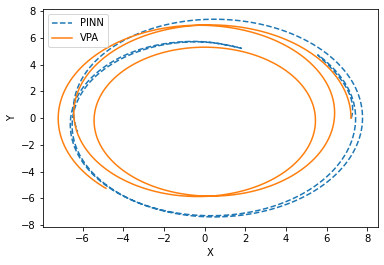

In [30]:
#绘制轨迹，2维
plt.plot(x_coordinates,y_coordinates,linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt,label='VPA')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN results VS classic results')
plt.show()

In [447]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


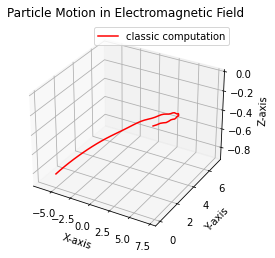

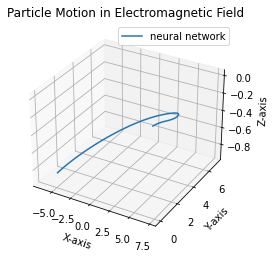

In [448]:
# 绘制轨迹 3维
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/50)], y_plt[::int(n_all/50)] ,z_plt[::int(n_all/50)],color='red',label='VPA')
#ax.plot(x_coordinates[::int(n_all/100)],y_coordinates[::int(n_all/100)],z_coordinates[::int(n_all/100)],label='neural network')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_plt[::int(n_all/100)], y_plt[::int(n_all/100)] ,z_plt[::int(n_all/100)],label='classic computation')
ax.plot(x_coordinates[::int(n_all/50)],y_coordinates[::int(n_all/50)],z_coordinates[::int(n_all/50)],label='PINN')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()

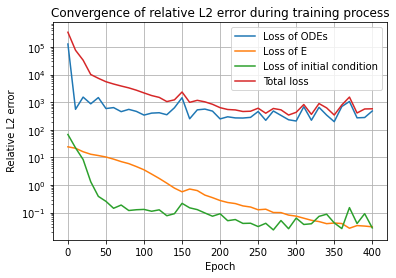

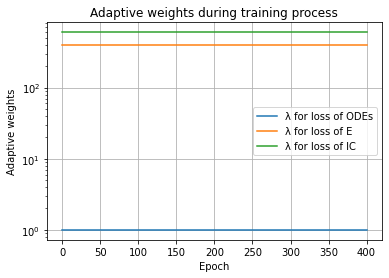

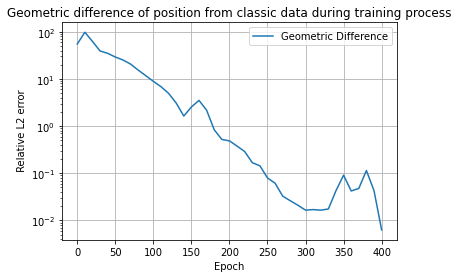

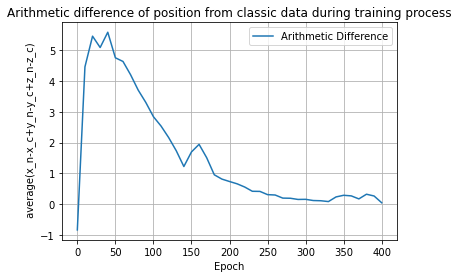

In [451]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
#plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Adaptive weights', fontsize='x-large')
# plt.title('Adaptive weights during training process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')

plt.show()#绘图

plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic difference of position from classic data during training process')

plt.show()#绘图

In [452]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),10):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[i-jump]
    y_real_tl = y_real_plt[i-jump]
    z_real_tl = z_real_plt[i-jump]
    vx_real_tl = vx_real_plt[i-jump]
    vy_real_tl = vy_real_plt[i-jump]
    vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 10*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


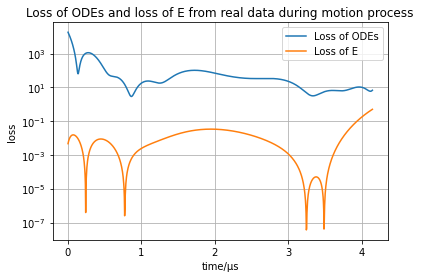

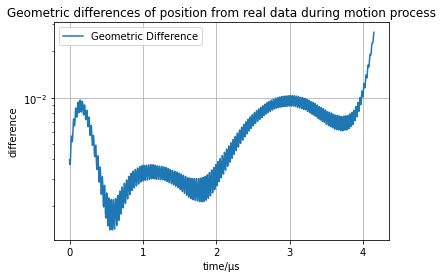

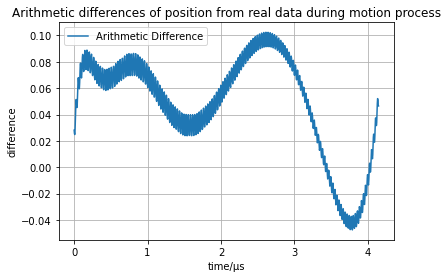

In [454]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()

plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图

plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [456]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
